In [1]:
#import modules
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
# The experiment has done with the 1000 LIMIT
 
LIMIT = 1000

In [3]:
# Import the domain data
domain =  pd.read_csv('domain.csv',nrows=LIMIT)

#import the page data
page =  pd.read_csv('page.csv',nrows=LIMIT)

#import the page links (page to page connections)
page_link =  pd.read_csv('page_link.csv',nrows=LIMIT)

In [4]:
#import the networkX module
import networkx as nx

#init the graph
G = nx.Graph()

In [5]:
#insert pages

for index, row in tqdm(page.iterrows()):
    G.add_node('p{}'.format(row.id), label='p')

In [6]:
#insert domain

for index, row in tqdm(domain.iterrows()):
    G.add_node('d{}'.format(row.id), label='d')

In [7]:
#insert page - domain edges

for index, row in tqdm(page.iterrows()):
    G.add_edge('p{}'.format(row.id), 'd{}'.format(row.domain), label='p2d' )

In [8]:
#insert page - page edges

for index, row in tqdm(page_link.iterrows()):
    G.add_edge('p{}'.format(row.link_from), 'p{}'.format(row.link_to), label='p2p' )

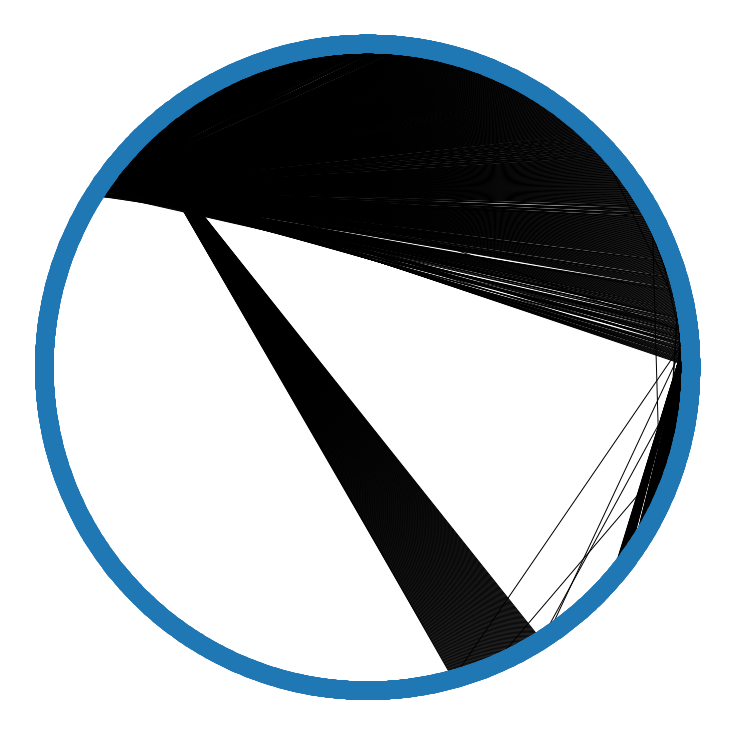

In [9]:
# plot graph spatial-temporal networks
import scipy
from matplotlib import pyplot as plt
plt.figure(3,figsize=(10,10)) 
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=not True)
plt.show()

In [10]:
#maximum digree
print(max(dict(G.degree()).items(), key = lambda x : x[1]))
#minium digree
print(min(dict(G.degree()).items(), key = lambda x : x[1]))

('p14817812', 353)
('d304892', 0)


In [11]:
#import the modules (stella graph)
import stellargraph as sg
from stellargraph import StellarGraph

In [12]:
#Convert networkX graph instance to  StellarGraph object
square = StellarGraph.from_networkx(G)

In [13]:
#view graph properties 
print(square.info())

StellarGraph: Undirected multigraph
 Nodes: 2523, Edges: 1983

 Node types:
  p: [1000]
    Features: none
    Edge types: p-p2d->d, p-p2p->default, p-p2p->p
  d: [1000]
    Features: none
    Edge types: d-p2d->p
  default: [523]
    Features: none
    Edge types: default-p2p->default, default-p2p->p

 Edge types:
    d-p2d->p: [1000]
        Weights: all 1 (default)
        Features: none
    default-p2p->default: [433]
        Weights: all 1 (default)
        Features: none
    default-p2p->p: [360]
        Weights: all 1 (default)
        Features: none
    p-p2p->p: [190]
        Weights: all 1 (default)
        Features: none


In [14]:
# Get number of connected components
nx.number_connected_components(G)

978

In [15]:
# return connected components as sub graphs
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [16]:
#sort the connected components based on the nodes
Gcc = sorted(connected_component_subgraphs(G), key=len, reverse=True)
cc_sizes = []
for cc in list(Gcc):
    cc_sizes.append(len(cc.nodes()))
print(cc_sizes[:10])

[823, 110, 109, 107, 105, 104, 104, 48, 9, 6]


In [17]:
import igraph as ig
# translate the object into igraph
g_ig = ig.Graph.Adjacency((nx.to_numpy_matrix(G) > 0).tolist(), mode=ig.ADJ_UNDIRECTED)
g_ig.summary()

'IGRAPH U--- 2523 1983 -- '

In [18]:
import random
# perform community detection
random.seed(123)
c_infomap = g_ig.community_infomap()
print(c_infomap.summary())

Clustering with 2523 elements and 1016 clusters


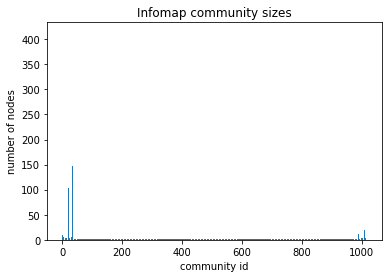

In [19]:
from matplotlib import pyplot as plt
# plot the community sizes
infomap_sizes = c_infomap.sizes()
plt.title("Infomap community sizes")
plt.xlabel("community id")
plt.ylabel("number of nodes")
plt.bar(list(range(1, len(infomap_sizes) + 1)), infomap_sizes)
plt.show()

In [20]:
# Modularity metric for infomap
c_infomap.modularity

0.8185952253255044

In [21]:
# assign community membership results back to networkx, keep the dictionary for later comparisons with the clustering
infomap_com_dict = dict(zip(list(G.nodes()), c_infomap.membership))
nx.set_node_attributes(G, infomap_com_dict, "c_infomap")

In [22]:
# com_id = max(c_infomap.sizes())  # smaller number - larger community, as it's sorted

In [23]:
L =list(map(lambda x:len(x.nodes()),connected_component_subgraphs(G)))
com_id = L.index(max(L))

In [24]:
# extraction of a subgraph from the nodes in this community
com_G = G.subgraph([n for n, attrdict in G.nodes.items() if attrdict["c_infomap"] == com_id])
print(nx.info(com_G))

Name: 
Type: Graph
Number of nodes: 11
Number of edges: 20
Average degree:   3.6364


### What we can gain from these identified communities 

By labeling the type of these pages and domains its very easy to have the idea of the relationship between the domains and the type of bitcoin address that they are interacting with. 


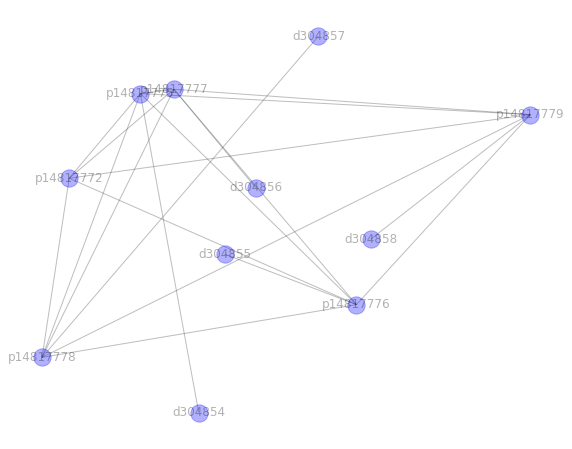

In [25]:
# plot community structure only
pos = nx.random_layout(com_G, seed=123)
plt.figure(figsize=(10, 8))
nx.draw_networkx(com_G, pos, edge_color="#26282b", node_color="blue", alpha=0.3)
plt.axis("off")
plt.show()